<a href="https://colab.research.google.com/github/Lakshmiluck2/FMMLAB-PROJECTS/blob/main/Copy_of_Module_7_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Module 7 Project: Movie Recommendation Engine

`Module Coordinator: Ganesh Chandan`

In this module, we will try to create a Movie Recommendation System using different unsupervised learning techniques.

In [ ]:

!wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip

--2025-02-05 09:39:28--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  3.32MB/s    in 0.3s    

2025-02-05 09:39:29 (3.32 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


## Clustering based recommendation

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score

In [ ]:

movies = pd.read_csv('ml-latest-small/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:

ratings = pd.read_csv('ml-latest-small/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:

print('The dataset contains: ', len(ratings), ' ratings of ', len(movies), ' movies.')

The dataset contains:  100836  ratings of  9742  movies.


### Romance versus Science Fiction

We will start by considering a subset of users and discovering what are their favourite genre. We will do this by defining a function that will calculate each user’s average rating for all science fiction and romance movies.

In [ ]:

def get_genre_ratings(ratings, movies, genres, column_names):
    genre_ratings = pd.DataFrame()
    for genre in genres:
        genre_movies = movies[movies['genres'].str.contains(genre) ]
        avg_genre_votes_per_user = ratings[ratings['movieId'].isin(genre_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)

        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)

    genre_ratings.columns = column_names
    return genre_ratings
genre_ratings = get_genre_ratings(ratings, movies, ['Romance', 'Sci-Fi'], ['avg_romance_rating', 'avg_scifi_rating'])
genre_ratings.head()

,avg_romance_rating,avg_scifi_rating
1,4.31,4.22
2,4.50,3.88
3,0.50,4.20
4,3.38,2.83
5,3.09,2.50


In order to have a more delimited subset of people to study, we are going to bias our grouping to only get ratings from those users that like either romance or science fiction movies.

In [ ]:

def bias_genre_rating_dataset(genre_ratings, score_limit_1, score_limit_2):
    biased_dataset =    genre_ratings[((genre_ratings['avg_romance_rating'] < score_limit_1 - 0.2) & (genre_ratings['avg_scifi_rating'] > score_limit_2)) | ((genre_ratings['avg_scifi_rating'] < score_limit_1) & (genre_ratings['avg_romance_rating'] > score_limit_2))]
    biased_dataset = pd.concat([biased_dataset[:300], genre_ratings[:2]])
    biased_dataset = pd.DataFrame(biased_dataset.to_records())
    return biased_dataset

biased_dataset = bias_genre_rating_dataset(genre_ratings, 3.2, 2.5)
print( "Number of records: ", len(biased_dataset))
biased_dataset.head()

Number of records:  162


,index,avg_romance_rating,avg_scifi_rating
0,3,0.50,4.20
1,4,3.38,2.83
2,5,3.09,2.50
3,7,2.65,3.15
4,9,3.17,3.00


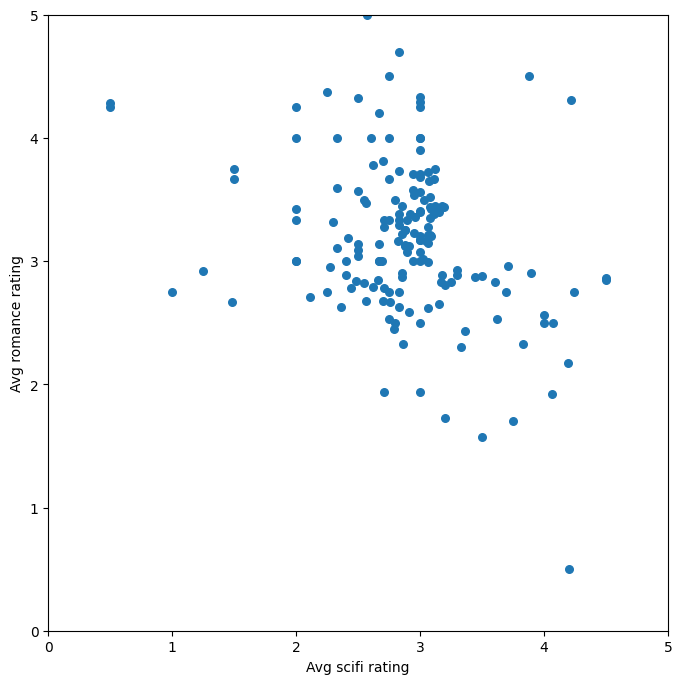

In [ ]:

def draw_scatterplot(x_data, x_label, y_data, y_label):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x_data, y_data, s=30)

draw_scatterplot(biased_dataset['avg_scifi_rating'],'Avg scifi rating', biased_dataset['avg_romance_rating'], 'Avg romance rating')

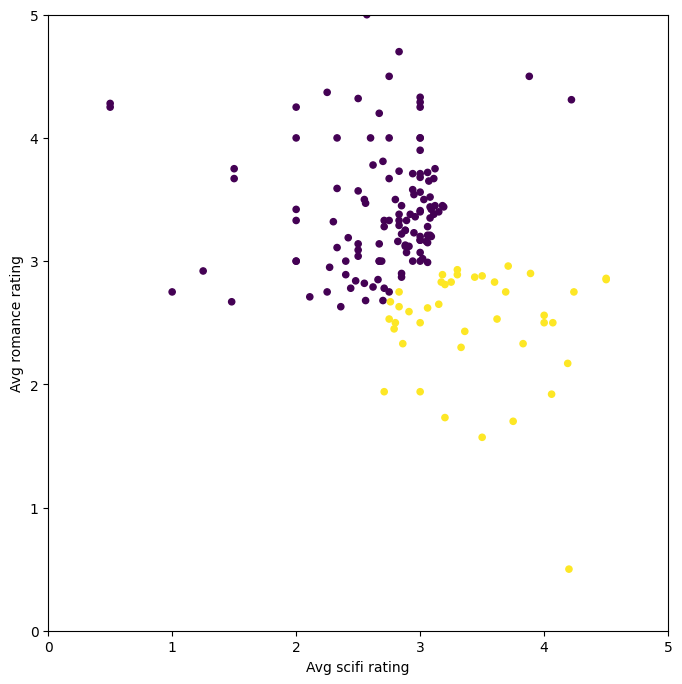

In [ ]:

X = biased_dataset[['avg_scifi_rating','avg_romance_rating']].values


from sklearn.cluster import KMeans

kmeans_1 = KMeans(n_clusters=2)

predictions = kmeans_1.fit_predict(X)

def draw_clusters(biased_dataset, predictions, cmap='viridis'):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg scifi rating')
    ax.set_ylabel('Avg romance rating')
    clustered = pd.concat([biased_dataset.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    plt.scatter(clustered['avg_scifi_rating'], clustered['avg_romance_rating'], c=clustered['group'], s=20, cmap=cmap)


draw_clusters(biased_dataset, predictions)

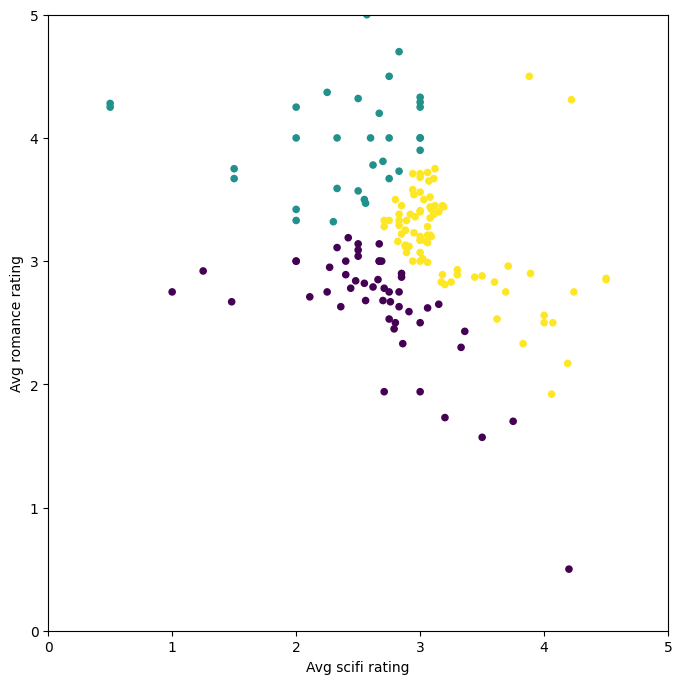

In [ ]:

kmeans_2 = KMeans(n_clusters=3)

predictions_2 = kmeans_2.fit_predict(X)

draw_clusters(biased_dataset, predictions_2)

It is evident now that the science-fiction rating has started to come into play:

    People who like sci-fi and romance modeately belong to the green group.
    People who like scifi but not romance belong to the yello group.
    People who like romance but not sci-fi belong to the purple group.

Finding optimal clusters using silhouette score

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (157) found smaller than n_clusters (162). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


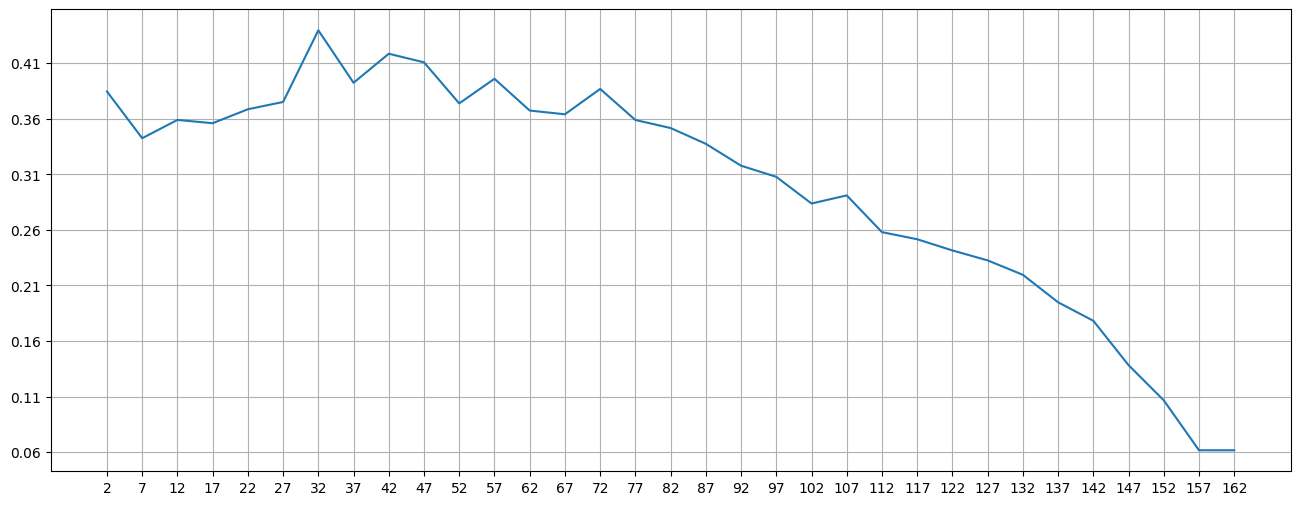

In [ ]:

df = biased_dataset[['avg_scifi_rating','avg_romance_rating']]

possible_k_values = range(2, len(X)+1, 5)

def clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)

    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg

errors_per_k = [clustering_errors(k, X) for k in possible_k_values]


fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(possible_k_values, errors_per_k)


xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

We will chose the K = 7 as it is the one that yields the best score and will be easier to visualize.



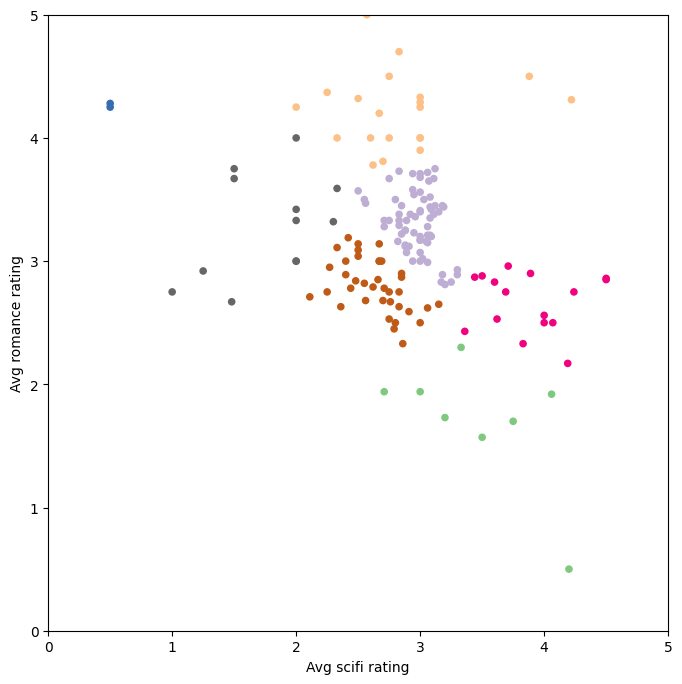

In [ ]:

kmeans_4 = KMeans(n_clusters=7)

predictions_4 = kmeans_4.fit_predict(X)

draw_clusters(biased_dataset, predictions_4, cmap='Accent')

Up to now, we have only analyzed romance and science-fiction movies. Let us see what happens when adding other genre to our analysis by adding Action movies.

In [ ]:

biased_dataset_3_genres = get_genre_ratings(ratings, movies, ['Romance','Sci-Fi', 'Action'],
['avg_romance_rating', 'avg_scifi_rating', 'avg_action_rating'])

biased_dataset_3_genres = bias_genre_rating_dataset(biased_dataset_3_genres, 3.2, 2.5).dropna()

print( "Number of records: ", len(biased_dataset_3_genres))
biased_dataset_3_genres.head()

Number of records:  161


,index,avg_romance_rating,avg_scifi_rating,avg_action_rating
0,3,0.50,4.20,3.57
1,4,3.38,2.83,3.32
2,5,3.09,2.50,3.11
3,7,2.65,3.15,3.26
4,9,3.17,3.00,3.12


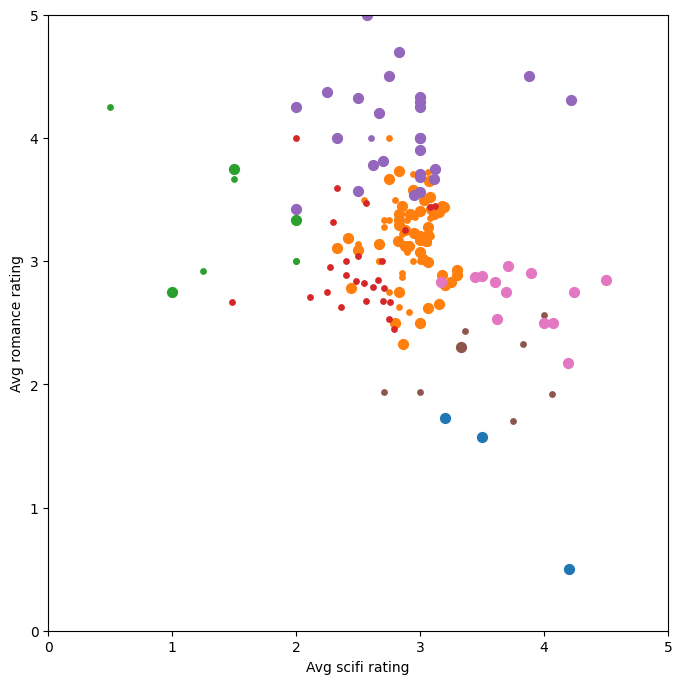

In [ ]:

X_with_action = biased_dataset_3_genres[['avg_scifi_rating','avg_romance_rating','avg_action_rating']].values# Create an instance of KMeans to find seven clusters
kmeans_5 = KMeans(n_clusters=7)

predictions_5 = kmeans_5.fit_predict(X_with_action)

def draw_clusters_3d(biased_dataset_3, predictions):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg scifi rating')
    ax.set_ylabel('Avg romance rating')
    clustered = pd.concat([biased_dataset_3.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    colors = itertools.cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])
    for g in clustered.group.unique():
        color = next(colors)
        for index, point in clustered[clustered.group == g].iterrows():
            if point['avg_action_rating'].astype(float) > 3:
                size = 50
            else:
                size = 15
            plt.scatter(point['avg_scifi_rating'],
                        point['avg_romance_rating'],
                        s=size,
                        color=color)# Plot
draw_clusters_3d(biased_dataset_3_genres, predictions_5)

The size of the dots represent the ratings of the action movies.

# Exercise 1

## Instead of choosing a n_clusters as 7, play around with different k
## Find the optimal no of clusters with 3 genre_ratings data we just created using silhouette score method

Optimal number of clusters: 2


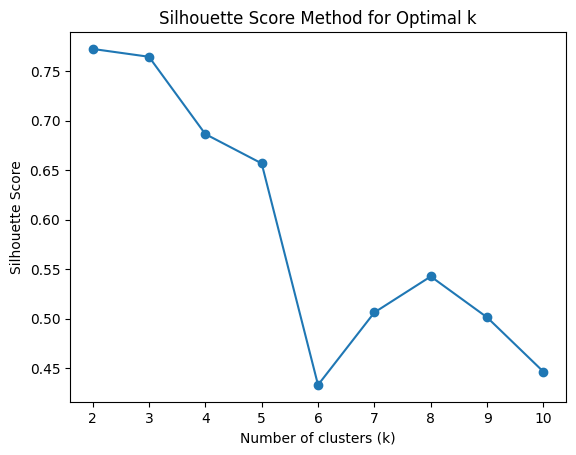

Data loaded from: /content/ml-latest-small.csv


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

file_path = ("/content/ml-latest-small.csv")
df = pd.read_csv('/content/ratings.csv')

df.fillna(df.mean(), inplace=True)

ratings_matrix = df.pivot_table(index='userId', columns='movieId', values='rating')

ratings_matrix.fillna(0, inplace=True)


scaler = StandardScaler()
ratings_matrix_scaled = scaler.fit_transform(ratings_matrix)

k_values = range(2, 11)
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(ratings_matrix_scaled)
    score = silhouette_score(ratings_matrix_scaled, labels)
    silhouette_scores.append(score)

optimal_k = k_values[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters: {optimal_k}")

plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method for Optimal k')
plt.show()


print(f"Data loaded from: {file_path}")


### Taking users into consideration

Once we have seen and understood how the K-Means algorithm group the users by their movie genre preferences, we are going to take a bigger picture of the dataset and explore how users rate individual movies.

To do so, we will subset the dataset by ‘userid’ vs ‘user rating’ as follows.

In [ ]:

ratings_title = pd.merge(ratings, movies[['movieId', 'title']], on='movieId' )
user_movie_ratings = pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')


print('dataset dimensions: ', user_movie_ratings.shape, '\n\nSubset example:')
user_movie_ratings.iloc[:6, :10]

dataset dimensions:  (610, 9719) 

Subset example:


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987)
userId,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
import pandas as pd

def get_most_rated_movies(user_movie_ratings, max_number_of_movies):
    movie_ratings_count = user_movie_ratings.notnull().sum(axis=0)
    user_movie_ratings_sorted = user_movie_ratings[movie_ratings_count.sort_values(ascending=False).index]
    most_rated_movies = user_movie_ratings_sorted.iloc[:, :max_number_of_movies]
    return most_rated_movies

def get_users_who_rate_the_most(most_rated_movies, n_users):
    most_rated_movies['num_ratings'] = most_rated_movies.notnull().sum(axis=1)
    most_rated_movies = most_rated_movies.sort_values(by=['num_ratings'], ascending=False)
    most_rated_movies = most_rated_movies.iloc[:n_users, :]
    most_rated_movies = most_rated_movies.drop('num_ratings', axis=1)
    return most_rated_movies

def sort_by_rating_density(user_movie_ratings, n_movies, n_users):
    most_rated_movies = get_most_rated_movies(user_movie_ratings, n_movies)
    most_rated_movies = get_users_who_rate_the_most(most_rated_movies, n_users)
    return most_rated_movies

n_movies = 30
n_users = 18
most_rated_movies_users_selection = sort_by_rating_density(user_movie_ratings, n_movies, n_users)

print('Dataset dimensions: ', most_rated_movies_users_selection.shape)
print(most_rated_movies_users_selection.head())


Dataset dimensions:  (18, 30)
title   Forrest Gump (1994)  Shawshank Redemption, The (1994)  \
userId                                                          
414                     5.0                               5.0   
590                     5.0                               4.5   
474                     3.0                               5.0   
480                     5.0                               5.0   
68                      3.5                               3.0   

title   Pulp Fiction (1994)  Silence of the Lambs, The (1991)  \
userId                                                          
414                     5.0                               4.0   
590                     4.5                               3.5   
474                     4.0                               4.5   
480                     4.0                               4.5   
68                      2.0                               3.5   

title   Matrix, The (1999)  Star Wars: Episode IV - A New 

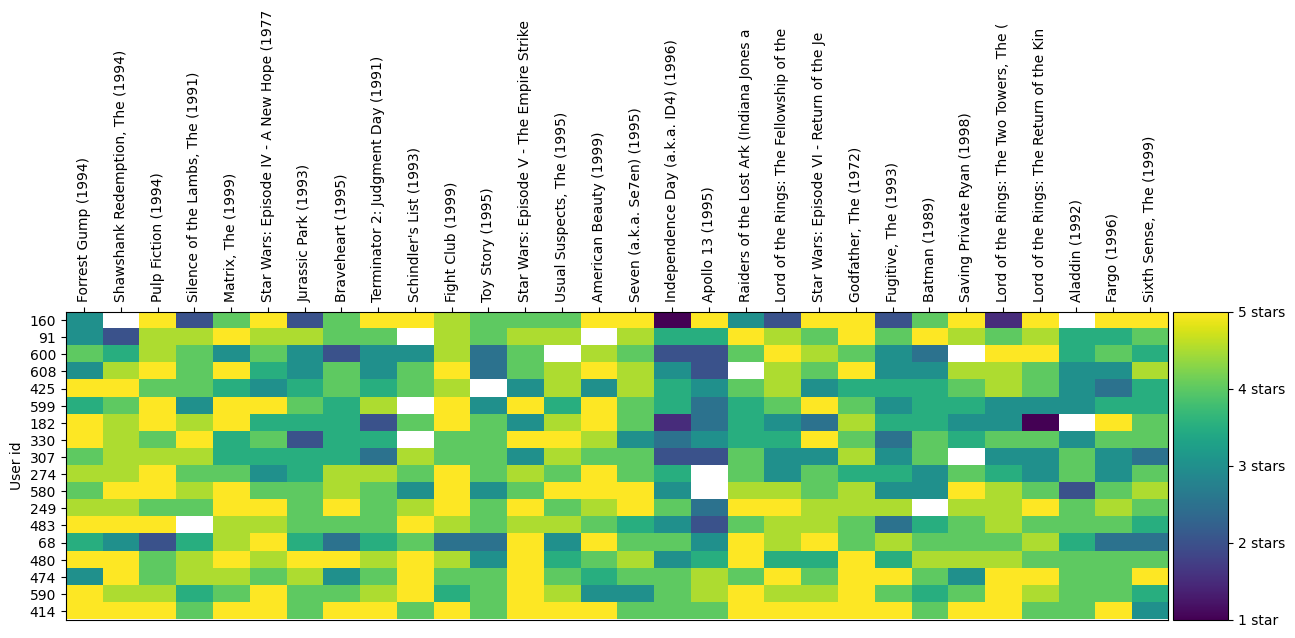

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def draw_movies_heatmap(most_rated_movies_users_selection, axis_labels=True):
    fig = plt.figure(figsize=(15, 4))
    ax = plt.gca()

    heatmap = ax.imshow(most_rated_movies_users_selection, cmap="viridis", aspect="auto")

    if axis_labels:
        ax.set_yticks(np.arange(most_rated_movies_users_selection.shape[0]), minor=False)
        ax.set_xticks(np.arange(most_rated_movies_users_selection.shape[1]), minor=False)
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        labels = most_rated_movies_users_selection.columns.str[:40]
        ax.set_xticklabels(labels, minor=False)
        ax.set_yticklabels(most_rated_movies_users_selection.index, minor=False)
        plt.setp(ax.get_xticklabels(), rotation=90)
    else:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    ax.grid(False)
    ax.set_ylabel('User id')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
    cbar.ax.set_yticklabels(['5 stars', '4 stars', '3 stars', '2 stars', '1 star', '0 stars'])
    plt.show()

draw_movies_heatmap(most_rated_movies_users_selection)


In [ ]:

user_movie_ratings =  pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')
most_rated_movies_1k = get_most_rated_movies(user_movie_ratings, 1000).replace(np.nan, 0)

In [ ]:
from scipy import sparse


sparse_ratings = sparse.csr_matrix(most_rated_movies_1k.values)

### Large Scale Clustering

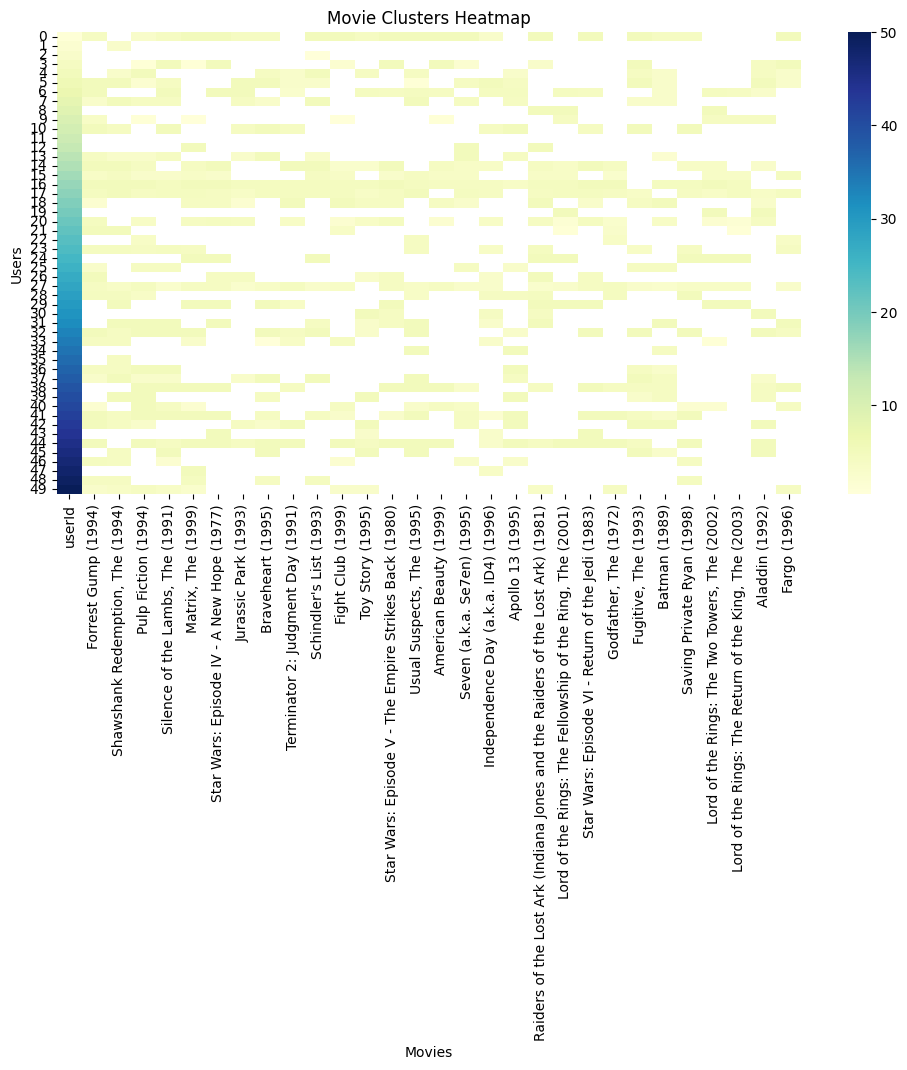

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

predictions = KMeans(n_clusters=20, algorithm='lloyd', random_state=42).fit_predict(sparse_ratings)

clustered = pd.concat([get_most_rated_movies(user_movie_ratings, 1000).reset_index(), pd.DataFrame({'group': predictions})], axis=1)

def draw_movie_clusters(clustered, max_users, max_movies):
    clustered_sorted = clustered.head(max_users).iloc[:, :max_movies]
    plt.figure(figsize=(12, 6))
    sns.heatmap(clustered_sorted, cmap='YlGnBu', annot=False, xticklabels=True, yticklabels=True)
    plt.title("Movie Clusters Heatmap")
    plt.xlabel("Movies")
    plt.ylabel("Users")
    plt.show()

draw_movie_clusters(clustered, max_users=50, max_movies=30)


### Predictions and Recommendation

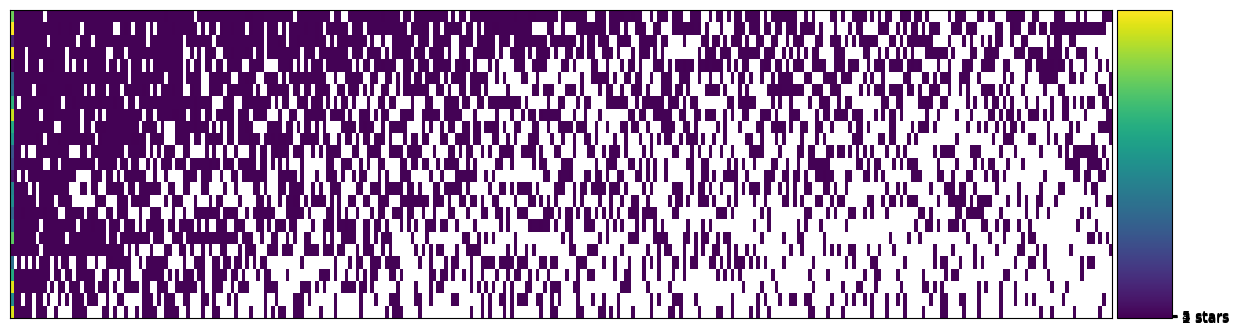

In [ ]:
cluster_number = 11
n_users = 75
n_movies = 300

cluster = clustered[clustered['group'] == cluster_number].reset_index(drop=True)
cluster = cluster.drop(['group'], axis=1)
cluster = sort_by_rating_density(cluster, n_movies, n_users)
draw_movies_heatmap(cluster, axis_labels=False)


In [ ]:

movie_name = "Matrix, The (1999)"
cluster[movie_name].mean()

4.368421052631579

In [ ]:

cluster.mean().head(20)

,0
userId,305.720000
Star Wars: Episode IV - A New Hope (1977),4.333333
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),4.456522
Star Wars: Episode VI - Return of the Jedi (1983),3.954545
Fargo (1996),4.545455
Star Wars: Episode V - The Empire Strikes Back (1980),4.295455
"Princess Bride, The (1987)",4.452381
"Fugitive, The (1993)",3.928571
"Godfather, The (1972)",4.690476
Forrest Gump (1994),3.880952


In [ ]:
cluster

,userId,Star Wars: Episode IV - A New Hope (1977),Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),Star Wars: Episode VI - Return of the Jedi (1983),Fargo (1996),Star Wars: Episode V - The Empire Strikes Back (1980),"Princess Bride, The (1987)","Fugitive, The (1993)","Godfather, The (1972)",Forrest Gump (1994),...,Natural Born Killers (1994),Cinema Paradiso (Nuovo cinema Paradiso) (1989),Sixteen Candles (1984),"O Brother, Where Art Thou? (2000)","Crouching Tiger, Hidden Dragon (Wo hu cang long) (2000)",Roger & Me (1989),"Thomas Crown Affair, The (1999)",Jackie Brown (1997),"Running Man, The (1987)",Conan the Barbarian (1982)
19,469,4.0,4.0,3.0,5.0,5.0,5.0,3.0,5.0,NaN,...,2.0,NaN,4.0,NaN,NaN,NaN,NaN,3.0,3.0,4.0
24,603,4.0,4.0,3.0,5.0,3.0,3.0,3.0,5.0,3.0,...,4.0,1.0,4.0,3.0,5.0,4.0,2.0,3.0,NaN,NaN
3,57,5.0,5.0,4.0,4.0,4.0,5.0,5.0,5.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,597,5.0,5.0,5.0,NaN,5.0,5.0,5.0,5.0,5.0,...,3.0,5.0,5.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN
1,19,4.0,5.0,3.0,NaN,4.0,5.0,4.0,NaN,2.0,...,NaN,NaN,3.0,NaN,NaN,NaN,4.0,NaN,2.0,NaN
7,202,4.0,5.0,3.0,4.0,5.0,4.0,3.0,4.0,5.0,...,NaN,4.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,5.0
8,217,5.0,5.0,5.0,5.0,5.0,NaN,4.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,NaN,1.0
17,391,5.0,NaN,4.0,5.0,5.0,5.0,4.0,5.0,5.0,...,NaN,5.0,NaN,3.0,5.0,NaN,NaN,2.0,3.0,NaN
20,555,5.0,4.0,5.0,5.0,5.0,5.0,4.0,NaN,5.0,...,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,5.0,2.0
15,368,4.0,4.0,4.0,4.0,3.0,5.0,3.0,5.0,4.0,...,3.0,NaN,NaN,NaN,NaN,NaN,3.0,3.0,2.0,2.0


In [ ]:
user_id = 7
user_2_ratings = cluster.loc[user_id, :]
user_2_unrated_movies = user_2_ratings[user_2_ratings.isnull()]
avg_ratings = pd.concat([user_2_unrated_movies, cluster.mean()], axis=1, join='inner').loc[:,0]
avg_ratings.sort_values(ascending=False)[:20]


,0
Chinatown (1974),4.800000
One Flew Over the Cuckoo's Nest (1975),4.666667
Schindler's List (1993),4.625000
Rear Window (1954),4.607143
Raging Bull (1980),4.555556
Amadeus (1984),4.541667
Goodfellas (1990),4.500000
"Deer Hunter, The (1978)",4.500000
This Is Spinal Tap (1984),4.409091
Dazed and Confused (1993),4.375000


## Using Collaborative Filtering (With fast.ai)

In [ ]:
! [ -e /content ] && pip install -Uqq fastai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 829.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.9 MB/s eta 0:00:00
!pip install -U fastai


In [ ]:
from fastai.tabular.all import *
from fastai.collab import *

### Training a model

For this, we will use the [Movielens 100k data dataset](https://grouplens.org/datasets/movielens/100k/). We can download it easily and decompress it with the following function:

In [ ]:
path = untar_data(URLs.ML_100k)

The main table is in `u.data`. Since it's not a proper csv, we have to specify a few things while opening it: the tab delimiter, the columns we want to keep and their names.

In [ ]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      usecols=(0,1,2), names=['user','movie','rating'])
ratings.head()

,user,movie,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


Movie ids are not ideal to look at things, so we load the corresponding movie id to the title that is in the table `u.item`:

In [ ]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


Next we merge it to our ratings table:

In [ ]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,title
0,196,242,3,Kolya (1996)
1,186,302,3,L.A. Confidential (1997)
2,22,377,1,Heavyweights (1994)
3,244,51,2,Legends of the Fall (1994)
4,166,346,1,Jackie Brown (1997)


We can then build a `DataLoaders` object from this table. By default, it takes the first column for user, the second column for the item (here our movies) and the third column for the ratings. We need to change the value of `item_name` in our case, to use the titles instead of the ids:

In [ ]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)

In all applications, when the data has been assembled in a `DataLoaders`, you can have a look at it with the `show_batch` method:

In [ ]:
dls.show_batch()

,user,title,rating
0,94,Vanya on 42nd Street (1994),5
1,590,Swingers (1996),5
2,659,Chinatown (1974),4
3,198,Happy Gilmore (1996),3
4,883,Vertigo (1958),5
5,78,"Very Brady Sequel, A (1996)",4
6,94,Alien 3 (1992),3
7,624,Phenomenon (1996),3
8,401,My Own Private Idaho (1991),4
9,320,Black Sheep (1996),4


fastai can create and train a collaborative filtering model by using `collab_learner`:

In [ ]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

It uses a simple dot product model with 50 latent factors. To train it using the 1cycle policy, we just run this command:

In [ ]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.905671,0.971129,00:08
1,0.679705,0.912531,00:07
2,0.534658,0.888577,00:07
3,0.469892,0.879179,00:08
4,0.441323,0.873962,00:07


Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on RMSE of 0.91 (scroll down to the 100k dataset), which corresponds to an MSE of `0.91**2 = 0.83`. So in less than a minute, we got pretty good results!

### Interpretation

Let's analyze the results of our previous model. We will keep the 1000 most rated movies for this:

In [ ]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)',
       'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)',
       'Air Force One (1997)', 'Independence Day (ID4) (1996)'],
      dtype=object)

### Movie bias

Our model has learned one bias per movie, a unique number independent of users that can be interpreted as the intrinsic "value" of the movie. We can grab the bias of each movie in our `top_movies` list with the following command:

In [ ]:
movie_bias = learn.model.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

Let's compare those biases with the average ratings:

In [ ]:
mean_ratings = ratings.groupby('title')['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

Now let's have a look at the movies with the worst bias:

In [ ]:
item0 = lambda o:o[0]
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3179), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0.3096), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2967),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.2964), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.2817), 'Kansas City (1996)', 2.260869565217391),
 (tensor(-0.2676), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2625), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2569), 'Halloween: The Curse of Michael Myers (1995)', 2.2),
 (tensor(-0.2554), 'Booty Call (1997)', 2.1666666666666665),
 (tensor(-0.2473), 'Beverly Hills Ninja (1997)', 2.3125),
 (tensor(-0.2377), 'Beautician and the Beast, The (1997)', 2.313953488372093),
 (tensor(-0.2299),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2285), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.2235), 'Two if by Sea (1996)', 2.6),
 (tensor(-0.2129), 'Hellra

Or the ones with the best bias:

In [ ]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.6065), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.6054), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5712), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.5313), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.5190), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.5040), 'Vertigo (1958)', 4.251396648044692),
 (tensor(0.4939), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.4934), 'Godfather, The (1972)', 4.283292978208232),
 (tensor(0.4824), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.4743), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.4677), 'Apt Pupil (1998)', 4.1),
 (tensor(0.4465), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.4438), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.4390), 'Full Monty, The (1997)', 3.926984126984127),
 (tensor(0.4302), 'Raiders of the Lost Ark (1981)', 4.252380952380952)]

There is certainly a strong correlation!

### Movie weights

Now let's try to analyze the latent factors our model has learned. We can grab the weights for each movie in `top_movies` the same way as we did for the bias before.

In [ ]:
movie_w = learn.model.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 50])

Let's try a PCA to reduce the dimensions and see if we can see what the model learned:

In [ ]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [ ]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

Here are the highest score on the first dimension:

In [ ]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.1334), 'Casablanca (1942)'),
 (tensor(1.0443),
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)'),
 (tensor(1.0049), 'Wrong Trousers, The (1993)'),
 (tensor(0.9985), 'Third Man, The (1949)'),
 (tensor(0.9783), 'Close Shave, A (1995)'),
 (tensor(0.9748), 'Godfather, The (1972)'),
 (tensor(0.9731), 'Wallace & Gromit: The Best of Aardman Animation (1996)'),
 (tensor(0.9607), 'Chinatown (1974)'),
 (tensor(0.9582), 'High Noon (1952)'),
 (tensor(0.9516), 'Ran (1985)')]

And the worst:

In [ ]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.3395), 'Jungle2Jungle (1997)'),
 (tensor(-1.1174), 'Leave It to Beaver (1997)'),
 (tensor(-1.1118), "McHale's Navy (1997)"),
 (tensor(-1.0629), 'Home Alone 3 (1997)'),
 (tensor(-1.0421), 'Halloween: The Curse of Michael Myers (1995)'),
 (tensor(-1.0317), 'Free Willy 3: The Rescue (1997)'),
 (tensor(-0.9941), 'Flintstones, The (1994)'),
 (tensor(-0.9941), 'Lawnmower Man 2: Beyond Cyberspace (1996)'),
 (tensor(-0.9822), 'D3: The Mighty Ducks (1996)'),
 (tensor(-0.9730), 'Flipper (1996)')]

Same thing for our second dimension:

In [ ]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [ ]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.3645), 'Braveheart (1995)'),
 (tensor(1.1204), 'Titanic (1997)'),
 (tensor(0.9994), 'Raiders of the Lost Ark (1981)'),
 (tensor(0.9307), "It's a Wonderful Life (1946)"),
 (tensor(0.8834), 'Independence Day (ID4) (1996)'),
 (tensor(0.8198), 'American President, The (1995)'),
 (tensor(0.8095), 'Pretty Woman (1990)'),
 (tensor(0.8047), 'Air Force One (1997)'),
 (tensor(0.7991), 'Back to the Future (1985)'),
 (tensor(0.7975), 'Phenomenon (1996)')]

In [ ]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-0.8688), 'Lost Highway (1997)'),
 (tensor(-0.8575), 'Three Colors: Blue (1993)'),
 (tensor(-0.8537), 'Serial Mom (1994)'),
 (tensor(-0.8136), 'Trainspotting (1996)'),
 (tensor(-0.7807), 'Natural Born Killers (1994)'),
 (tensor(-0.7549), 'Pillow Book, The (1995)'),
 (tensor(-0.7475), 'Stuart Saves His Family (1995)'),
 (tensor(-0.7319), 'Cabin Boy (1994)'),
 (tensor(-0.7244), 'Beavis and Butt-head Do America (1996)'),
 (tensor(-0.7221), 'Keys to Tulsa (1997)')]

And we can even plot the movies according to their scores on those dimensions:

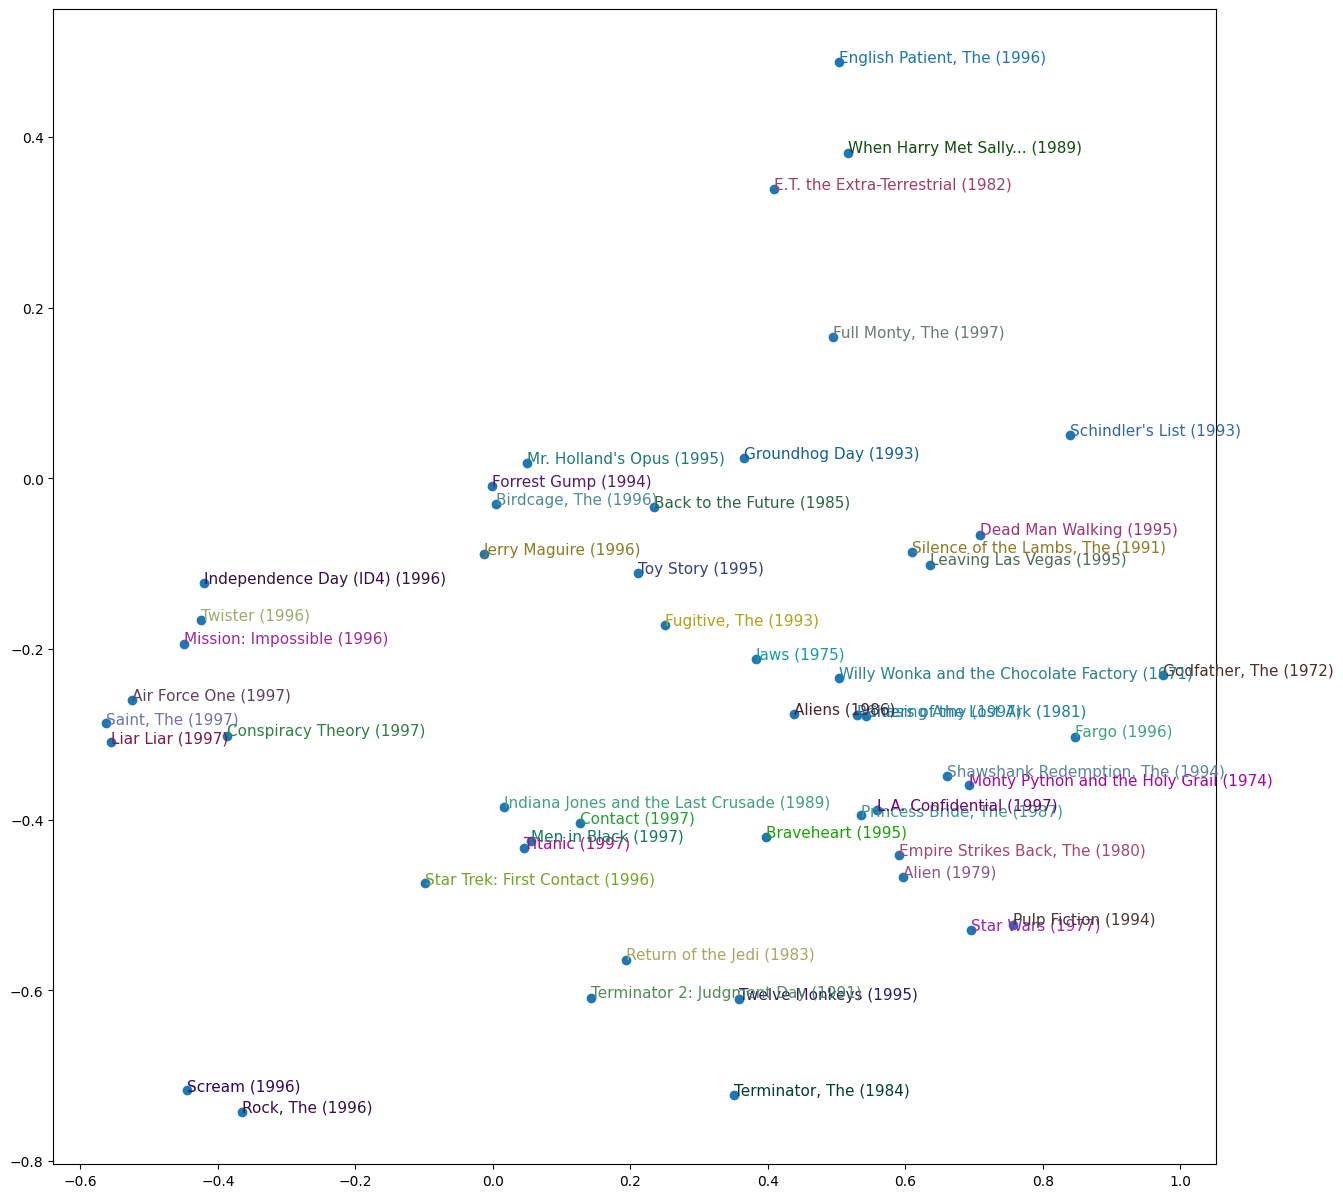

In [ ]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

# Exercise 2

## Play around with different collaborative filtering model parameters such as n_factors and other parameters.
## Identify if any such parameters have impact on the speed of convergence or the performance on the model

In [ ]:
!pip install scikit-surprise


  Using cached scikit_surprise-1.1.4.tar.gz (154 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2505172 sha256=96f420527b6ed36f5e4537cfa0263f33735906b0f8226d4ae3bc4ce0268b0813
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


In [ ]:
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy
import pandas as pd

data_path = '/content/u.data'

reader = Reader(line_format='user item rating timestamp', sep='\t')
data = Dataset.load_from_df(pd.read_csv(data_path, sep='\t', header=None, names=['user', 'item', 'rating', 'timestamp'])[['user', 'item', 'rating']], reader)

trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

model = SVD(n_factors=100, n_epochs=20, lr_all=0.005, reg_all=0.02)
model.fit(trainset)

predictions = model.test(testset)

rmse = accuracy.rmse(predictions)
mse = accuracy.mse(predictions)

print(f"RMSE: {rmse}")
print(f"MSE: {mse}")

model = SVD(n_factors=50, n_epochs=10, lr_all=0.01, reg_all=0.1)
model.fit(trainset)

predictions = model.test(testset)

rmse = accuracy.rmse(predictions)
mse = accuracy.mse(predictions)

print(f"RMSE: {rmse}")
print(f"MSE: {mse}")

model = SVD(n_factors=150, n_epochs=30, lr_all=0.001, reg_all=0.05)
model.fit(trainset)

predictions = model.test(testset)

rmse = accuracy.rmse(predictions)
mse = accuracy.mse(predictions)

print(f"RMSE: {rmse}")
print(f"MSE: {mse}")


RMSE: 0.9356
MSE: 0.8753
RMSE: 0.9355818957964485
MSE: 0.8753134837420766
RMSE: 0.9413
MSE: 0.8860
RMSE: 0.9412903700216765
MSE: 0.8860275606955447
RMSE: 0.9576
MSE: 0.9170
RMSE: 0.9575923211098116
MSE: 0.9169830534484765
